In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy as sci
import scipy.io as sio

In [2]:
#reading in the peak bed file
peaks = pd.read_csv("E:/scrnaseqscript/foxa1_data/h2_data/H2_bedpeaksfoxa1_new.bed", sep= "\t", header = None)
peaks.columns = ["chr", "start", "end"]
peaks["region"] = peaks["start"].astype(str) + "_" + peaks["end"].astype(str)
peaks["total"] = peaks["chr"].astype(str) + "_" + peaks["region"].astype(str)
peaks.head()

,chr,start,end,region,total
0,chr1,3045609,3046110,3045609_3046110,chr1_3045609_3046110
1,chr1,3046216,3046717,3046216_3046717,chr1_3046216_3046717
2,chr1,3081059,3081560,3081059_3081560,chr1_3081059_3081560
3,chr1,3104358,3104859,3104358_3104859,chr1_3104358_3104859
4,chr1,3129212,3129713,3129212_3129713,chr1_3129212_3129713


In [3]:
#reading in the table from the ReadInAnnotations script
viable = pd.read_csv("E:/scrnaseqscript/foxa1_data/h2_data/novel_peak_table_H2.tsv", header = 0, sep = "\t")

In [4]:
#read in peak counts and peak cell ids
counts = sio.mmread("E:/scrnaseqscript/foxa1_data/h2_data/foxA1_peak_counts_H2.mtx")
cell_idsatac = pd.read_csv("E:/scrnaseqscript/foxa1_data/h2_data/H2peakcelltypes.txt", header = 0, sep = "\t")
cell_idsrna = pd.read_csv("E:/scrnaseqscript/foxa1_data/h2_data/H2rnacelltypes.txt", header = 0, sep = "\t")
cell_idsatac.columns = ['celltype']
cell_idsrna.columns = ['celltype']
celltypes = cell_idsatac['celltype']
cell_idrna = cell_idsrna['celltype']
cell_ids = cell_idsatac['celltype']
counts.columns = celltypes
counts.rows = peaks['total']

In [5]:
names = viable['total']
names = names.to_list()
names = set(names)
crw = counts.rows.to_list()
c = [i for i, e in enumerate(crw) if e in names]
counts = counts.tocsr()[c,:]
crw = [e for i, e in enumerate(crw) if e in names]
counts.rows = crw
counts.columns = cell_ids
viable = viable[['chr','start','end', 'id', 'strand', 'region', 'total']]
viable.columns = ['chr','start','end', 'gene', 'strand', 'region', 'peak']
#genecol = newdf['Gene Name']
genecol = viable['gene']
gene_table = pd.DataFrame(crw)
genecol = genecol.reset_index()
genecol.head()

,index,gene
0,0,Xkr4
1,1,Xkr4
2,2,Mrpl15
3,3,Mrpl15
4,4,"Lypla1,Mrpl15"


In [6]:
gene_table.columns = ["peak"]
gene_table2 = pd.merge(gene_table, viable, on='peak')
gene_table2 = gene_table2[['peak', 'chr', 'start', 'end', 'gene']]
gene_table2.head()

,peak,chr,start,end,gene
0,chr1_3670858_3671359,chr1,3670858,3671359,Xkr4
1,chr1_3671503_3672004,chr1,3671503,3672004,Xkr4
2,chr1_4742592_4743093,chr1,4742592,4743093,Mrpl15
3,chr1_4755996_4756497,chr1,4755996,4756497,Mrpl15
4,chr1_4765057_4765558,chr1,4765057,4765558,"Lypla1,Mrpl15"


# read in the normalized rna expression matrix, features.tsv are the name of the rna features to complete the mtx file

In [7]:
#import pandas as pd
rna_expression = sio.mmread('E:/scrnaseqscript/foxa1_data/h2_data/foxA1_rna_counts_H2.mtx')
to_meta = pd.read_csv('E:/scrnaseqscript/foxa1_data/h2_data/H2_rna_features.tsv', sep = '\t', header = 0)
to_meta.columns = ['gene']
rna_expression.rows = to_meta['gene']
rna_expression.columns = cell_idrna
gene_table = gene_table2
gene_list_left = list(set(gene_table['gene']))
left2 = []

for i in gene_list_left:
    [left2.append(j) for j in i.split(",")]

gene_list_left= set(left2)

# Make a file with the list of peaks we are using and generate background peaks in R generatingbackgroundpeaks script

In [8]:
gene_table2['peak'].to_csv('E:/scrnaseqscript/foxa1_data/h2_data/H2_peaks_used_in_background.csv')

# Generate background peaks in R and then import them here, observed spearman values will be calculated

In [10]:
background = pd.read_csv("E:/scrnaseqscript/foxa1_data/h2_data/backgroundpeaks_H2.txt", header = 0, sep = " ", index_col = 0)
crw2 = [i.split("_") for i in crw]
crw2 = [i[0] + ":" + str(i[1]) + "-" + str(i[2]) for i in crw2]

background = background.apply(pd.to_numeric)

float_col = background.select_dtypes(include=['float64'])
for col in float_col.columns.values:
    background[col] = background[col].astype('int64')

peakslist = []
for index, row in background.iterrows():
    peakslist.append(index)

finw = viable
finw["peak2"] = finw["chr"] + "_" +finw['start'].astype(str) + "-" + finw["end"].astype(str)
s = finw['gene'].str.split(',',expand=True).stack()
finw = finw.reindex(finw.index.repeat(finw['gene'].fillna("").str.split(',').apply(len))) 
finw = finw.reset_index(drop=True)
finw['gene'] = s.to_list()
tempy= counts.rows
finw = finw.reset_index(drop=True)
gene_list_left= set(left2)

In [11]:
import scipy.stats as stats
observed = []
print(len(gene_list_left))
count = 0
for gene in gene_list_left:
    #gene = gene_list_left[gene]
    geneind = finw.index[finw['gene'] == gene].tolist()
    firstcor = finw.iloc[geneind]
    firstcor = firstcor['peak']
    rna = rna_expression.rows[rna_expression.rows == gene].index.values[0]
    rna = rna_expression.tocsr()[rna,:]
    rna = rna.toarray()
    for i in firstcor:
        #spearresults = []
        #indices, tospear = find_background_distribution(i)
        #geneind2 = gene_table.index[gene_table['peak'] == i].tolist()
        #if len(indices) > 30:
        #geneind2 = finw.index[gene_table['peak'] == i].tolist()
        geneind2 = [j for j, e in enumerate(tempy) if i == e]
        if len(geneind2) == 0:
            print(gene)
            print(i)
        corr = counts.tocsr()[geneind2, : ]
        corr = corr.toarray()
        spearresults = [stats.spearmanr(a = corr[j], b = rna, axis = 1)[0] for j in range(len(corr))]
            
            #observed = stats.spearmanr(a = corr[i], b = rna, axis = 1)[0]
            #print(spearresults)
        #    background_distributions.append((i, statistics.mean(spearresults), statistics.stdev(spearresults)))
        #else:
        #spearresults = [stats.spearmanr(a = corr[j], b = rna, axis = 1)[0] for j in range(len(corr))]
        if not np.isnan(spearresults):
            observed.append((i, gene, spearresults[0]))
        else:
            print(rna)
            print(sum(rna))
            print(sum(rna[0]))

    if count % 500 == 0:
        print(len(observed))
    count += 1


14268
22
16862
33922
50722
67167
83787
101037
117484
134786
152178
168535
185145
201887
219380
235982
252833
270375
287447
304907
321685
338457
355497
372803
389685
406867
423978
440850
457345
474284


# background peak bias correction and then merge with observed

In [12]:

def find_background_distribution(peak):
    #print(peak)
    peak2 = peak.split("-")[0] + "_" + peak.split("-")[1]
    #print(peak2)
    row = background.loc[peak2]
    bgs1 = row.to_numpy()
    bgs1 = [i-1 for i in bgs1]
    bgs = [peakslist[i] for i in bgs1]
    
    #bgs = [i for i in bgs if i != index]
    return bgs1, bgs
    #break
    #background_distributions.append((index, mean, stdev))
#len(find_background_distribution("chr16_18533123-18533423"))

In [13]:
import statistics
gene_list_left= set(left2)
background_distributions = []
print(len(gene_list_left))
count = 0
for gene in gene_list_left:
    #gene = gene_list_left[gene]
    geneind = finw.index[finw['gene'] == gene].tolist()
    firstcor = finw.iloc[geneind]
    firstcor = firstcor['peak2']
    
    rna = rna_expression.rows[rna_expression.rows == gene].index.values[0]
    rna = rna_expression.tocsr()[rna,:]
    rna = rna.toarray()
    for i in firstcor:
        spearresults = []
        indices, tospear = find_background_distribution(i)
        #geneind2 = gene_table.index[gene_table['peak'] == i].tolist()
        corr = counts.tocsr()[indices, : ].toarray()
        spearresults = [stats.spearmanr(a = j, b = rna, axis = 1)[0] for j in corr]
        background_distributions.append((i, gene, statistics.mean(spearresults), statistics.stdev(spearresults)))
    #break
    if count % 100 == 0:
        print(len(background_distributions))
    count += 1
background_distributions = pd.DataFrame(background_distributions)

14268
22
3541
6840
10035
13125
16862
20456
23857
27190
30548
33922
37167
40557
43871
47513
50722
54077
57226
60732
63917
67167
70434
73793
76936
80258
83787
87056
90534
94062
97449
101037
104493
108058
111026
114360
117484
121073
124590
128209
131404
134786
138492
142034
145366
148620
152178
155774
159171
162354
165544
168535
171870
175128
178382
181750
185145
188903
192308
195487
198621
201887
205207
208915
212602
215771
219380
222637
225703
229009
232414
235982
239289
242413
246107
249334
252833
256228
259626
263318
266766
270375
273563
277008
280464
284005
287447
291035
294466
298127
301518
304907
308221
311330
315019
318155
321685
324856
328231
331683
335104
338457
341987
345399
348687
352106
355497
358891
362645
366008
369304
372803
376012
379219
382653
386038
389685
392984
396673
400076
403711
406867
410492
413841
417110
420568
423978
427263
430788
434019
437287
440850
444257
447605
450815
453938
457345
460516
463887
467480
470717
474284
477634
480912


In [74]:
#background_distributions.to_csv("foxa1_data/backgdist_g2.txt", sep = '\t', header = False, index = False)

In [14]:
background_distributions.columns = ['peak', 'gene', 'mean', 'stdev']
gene_list_left= set(left2)
observed = pd.DataFrame(observed)
observed.columns = ['peak', 'gene', 'observed']
background_distributions['peak'] = background_distributions['peak'].str.replace('-','_')
table = pd.merge(observed, background_distributions, how = 'left', left_on = ['peak', 'gene'], right_on=['peak', 'gene'])
table['zscore'] = (table['observed'] - table['mean'])/table['stdev']
table['pval'] = sci.stats.norm.sf(abs(table['zscore']))
table.head()

,peak,gene,observed,mean,stdev,zscore,pval
0,chr7_46130601_46131102,Abcc8,0.060370,0.024950,0.017346,2.041916,0.020580
1,chr7_46131148_46131649,Abcc8,0.000355,0.028655,0.018392,-1.538724,0.061936
2,chr7_46131696_46132197,Abcc8,0.016004,0.006772,0.018534,0.498104,0.309205
3,chr7_46138315_46138816,Abcc8,0.025970,0.011932,0.015264,0.919633,0.178882
4,chr7_46139530_46140031,Abcc8,0.005198,0.006630,0.018254,-0.078455,0.468733


In [17]:
table.to_csv("E:/scrnaseqscript/foxa1_data/h2_data/final_background_correlations2.txt", sep = '\t', header = True, index = False)

# REMOVING PSEUDO-GENES (OPTIONAL)

In [18]:
table = table.reset_index(drop = True)
tablestr = ~(table['gene'].str[:2] == "Gm")
tablestr = (tablestr.tolist())
tablestr_index = [i for i, e in enumerate(tablestr) if e == True]
table = table.iloc[tablestr_index]
table = table.reset_index(drop = True)
table = table.loc[~table['gene'].str[0].str.isdigit()]
table = table.reset_index(drop = True)

# continue to create DORC plot and export final associated peaks

In [19]:
table = table.loc[table.groupby('peak').pval.idxmin()].reset_index(drop=True)
table = table[table.pval < 0.05 ]
x = table['gene'].value_counts(dropna=True)
y = table['gene'].value_counts(dropna=True).index

x = x.to_list()
y = y.to_list()

temp = pd.DataFrame(table['gene'].value_counts(dropna=True))

tempjr = table['gene'].value_counts(dropna=True).index

tempjr = [i for i in tempjr]

gene_list_left = list(set(gene_table['gene']))

In [20]:
for i in gene_list_left:
    if i not in set(tempjr):
        #print(i)
        temp.loc[i] = [0]

for index, row in temp.iterrows():
    if row['gene'] >= 7 and row['gene'] <= 10:
        temp.loc[index, 'val'] = "7-10"
    elif row['gene'] >= 10:
        temp.loc[index, 'val'] = ">10"
    else:
        temp.loc[index, 'val'] = row['gene']

for index, row in temp.iterrows():
    temp.loc[index, 'val'] = row['gene']

temp.head(n=10)

,gene,val
Fam71a,49,49
Krt16,48,48
Mybbp1a,40,40
Brf2,38,38
Krt8,31,31
Fadd,29,29
Wbscr25,26,26
Cbr4,24,24
Plet1os,23,23
Edn1,23,23


In [21]:
threetemp = temp['gene'].value_counts(dropna=True).index
threetempval = temp['gene'].value_counts(dropna=True)
temp = temp.reset_index()

# to anntotate the points look at the table above and hard code the gene names on

Text(0.5, 1.0, 'Identifying DORCs')

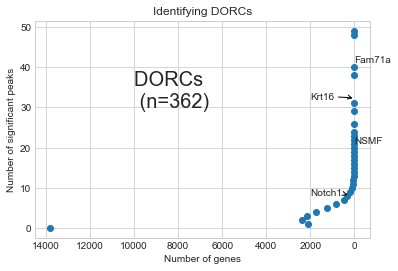

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

fig, ax = plt.subplots()
ax.scatter(threetempval,threetemp)
ax.annotate("Notch1", (239, 8), xytext = (2000, 8), arrowprops = dict(  arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))
#ax.text(239, 7, "Notch1")
ax.annotate("Krt16", (2, 32), xytext = (2000, 32), arrowprops = dict(  arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))
#ax.text(2, 32, "Cux1")
ax.text(10000, 30, "DORCs \n (n=" + str(len(temp[temp['gene'] >= 10])) + ")", size = 20)
ax.text(1, 41, "Fam71a")
ax.text(5, 21, "NSMF")
#ax.text(26, 19, "Krt79")
#ax.text(1, 53, "Col3a1", color = "red")
#ax.annotate("Nfatc1", (13, 21), xytext = (2000, 21), arrowprops = dict(  arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))
#ax.plot(threetempval, threetemp)
ax.invert_xaxis()
ax.set_xlabel('Number of genes')
ax.set_ylabel('Number of significant peaks')
ax.set_title('Identifying DORCs')


In [23]:
table['End'] = [i.split('_')[2] for i in table['peak']]
table['Start'] = [i.split('_')[1] for i in table['peak']]
table['peak'] = [i.split('_')[0] + '_' + i.split('_')[1] for i in table['peak']]
table.head()

,peak,gene,observed,mean,stdev,zscore,pval,End,Start
1,chr10_100001071,Kitl,0.051513,0.003000,0.016783,2.890560,0.001923,100001572,100001071
9,chr10_100017182,Kitl,0.063964,0.016722,0.018761,2.518133,0.005899,100017683,100017182
10,chr10_100017776,Kitl,0.050568,0.013061,0.018259,2.054118,0.019982,100018277,100017776
16,chr10_100028652,Kitl,0.030632,0.005565,0.014491,1.729842,0.041829,100029153,100028652
23,chr10_100051161,Kitl,0.067728,0.025078,0.021648,1.970195,0.024408,100051662,100051161


In [24]:
table.columns = ['peak', 'Gene', 'Corr', 'Mean', 'StDev', 'Zscore', 'Pvalue', 'End', 'Start']
table['NumCorr'] = table.groupby(['Gene'])['Gene'].transform('count')
table = table.reset_index(drop = True)

# WRITE TO CSV

In [25]:
table.to_csv('E:/scrnaseqscript/foxa1_data/h2_data/H2_dorcs_nopseudo.csv')